In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

import torch
import torch.nn as nn
from torch.distributions import constraints, transform_to
import torch.optim as optim
import torch.autograd as autograd

import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
from pyro.nn import PyroSample, PyroModule
from pyro.infer import autoguide, SVI, Trace_ELBO

In [2]:
print(torch.__version__)
print(pyro.__version__)

1.3.0.post2
1.0.0


In [3]:
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
def plot_obj(obj_function):

    steps = 1000
    strides = 200

    X1 = torch.linspace(const_x1_min, const_x1_max, steps)
    X2 = torch.linspace(const_x2_min, const_x2_max, steps)

    X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
    
    Z_mesh = obj_function(torch.stack((X1_mesh.flatten(), X2_mesh.flatten()), dim=1)).reshape(steps, steps)
    plt.contour(
        X1_mesh.detach().numpy(), 
        X2_mesh.detach().numpy(), 
        Z_mesh.detach().numpy(), strides)
    
    plt.colorbar()

In [4]:
def lower_confidence_bound(model, x, kappa=2):
    """ Lower Confidence Bound (LCB): $\alpha(x)=\mu(x) - \kappa\sigma(x)$ """
    
    mu, variance = model(x)
    sigma = variance.sqrt()
    
    return mu - kappa * sigma

normal_phi = lambda x: torch.exp(-x.pow(2)/2)/np.sqrt(2*np.pi)
normal_Phi = lambda x: (1 + torch.erf(x / np.sqrt(2))) / 2

def expected_improvement(model, x):
    """ Brooks' implementation of expected improvement (EI). """
    
    y_min = model.y.min()
    mu, variance = model(x)
    sigma = variance.sqrt()
    delta = y_min - mu
    EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
    
    return -EI

def acquisition_func(model, x, af='EI'):
    """ Defines acquisition function. """

    if af == "EI":
        return expected_improvement(model, x)
    elif af == "LCB":
        return lower_confidence_bound(model, x)
    else:
        return None

In [5]:
const_x1_min = -5
const_x1_max = 10

const_x2_min = 0
const_x2_max = 15

# Creating constraints
constr = [
    constraints.interval(const_x1_min, const_x1_max),
    constraints.interval(const_x2_min, const_x2_max)
]

def branin_hoo(x):
    """ Compute Branin-Hoo function for fixed constants """
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8 * np.pi)
    x1 = x[...,0]
    x2 = x[...,1]
    return a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1 - t)*torch.cos(x1) + s

# Checking LMs
branin_hoo_lms = torch.stack(
    (torch.tensor([-math.pi, math.pi, 9.42478]), 
     torch.tensor([12.275, 2.275, 2.475])), dim=1)

assert np.allclose(branin_hoo(branin_hoo_lms).numpy(),
        np.array([0.397887, 0.397887, 0.397887], dtype=np.float32), rtol=1e-6)

In [6]:
set_random_seed(555)

# Training points
N_train = 10
X_train = torch.rand(N_train, 2)*15 + torch.FloatTensor([const_x1_min, const_x2_min])
y_train = branin_hoo(X_train)

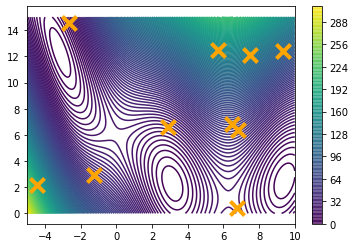

In [7]:
# Initial points
plot_obj(branin_hoo)
plt.scatter(X_train[:,0].detach().numpy(), X_train[:,1].detach().numpy(), marker="x", s=200, c='orange', zorder=2, linewidth=4);

# Setting autoguides explicitly

In [8]:
set_random_seed(123)

pyro.clear_param_store()

# Training 
gp_model_svi = gp.models.GPRegression(X_train, y_train, 
                                      gp.kernels.Matern52(input_dim=X_train.shape[1], 
                                                          lengthscale=100*torch.ones(X_train.shape[1])))

# Set priors
gp_model_svi.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(3, 1).expand([2]).to_event())
gp_model_svi.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(5, 2))
gp_model_svi.noise = pyro.nn.PyroSample(dist.LogNormal(0, 1))

# Set guides
gp_model_svi.kernel.autoguide("lengthscale", dist.Normal)
gp_model_svi.kernel.autoguide("variance", dist.Normal)
gp_model_svi.autoguide("noise", dist.Normal)

In [9]:
sorted(list(gp_model_svi.named_pyro_params()))

[('kernel.lengthscale_loc', Parameter containing:
  tensor([1.8031, 3.2093], requires_grad=True)),
 ('kernel.lengthscale_scale', tensor([1., 1.], grad_fn=<AddBackward0>)),
 ('kernel.variance_loc', Parameter containing:
  tensor(3.0553, requires_grad=True)),
 ('kernel.variance_scale', tensor(1., grad_fn=<AddBackward0>)),
 ('noise_loc', Parameter containing:
  tensor(-0.7550, requires_grad=True)),
 ('noise_scale', tensor(1., grad_fn=<AddBackward0>))]

In [10]:
# optimise
optimizer = torch.optim.Adam(gp_model_svi.parameters(), lr=0.1)
loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
losses = gp.util.train(gp_model_svi, optimizer, loss_fn, num_steps=1000)

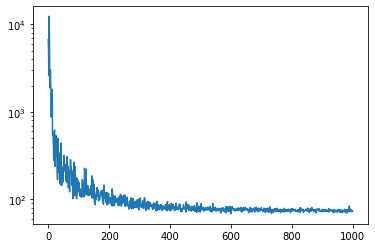

In [11]:
plt.semilogy(losses);

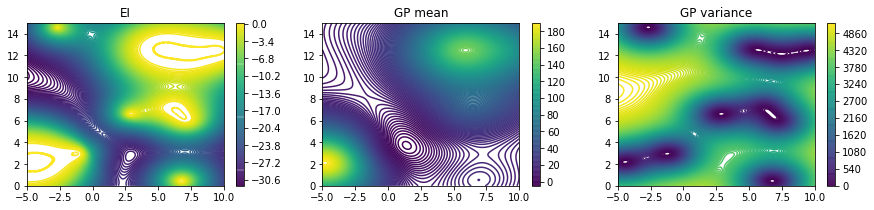

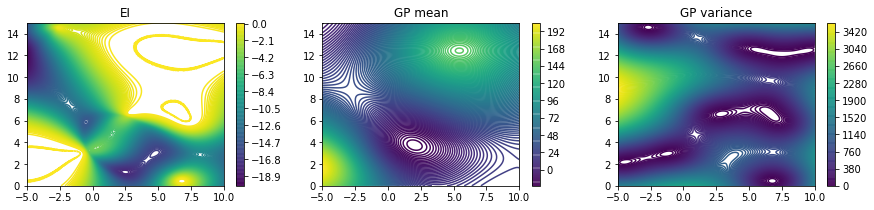

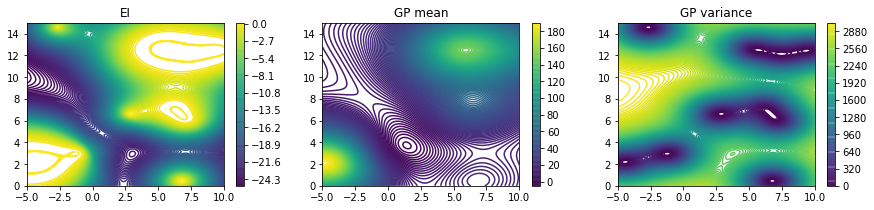

In [12]:
for i in range(3):
    plt.figure(figsize=(15, 3)) 

    with torch.no_grad(), gp_model_svi._pyro_context:
        plt.subplot(1,3,1)
        plt.title("EI")
        f = lambda x: acquisition_func(gp_model_svi, x)
        plot_obj(f)

        plt.subplot(1,3,2)
        plt.title("GP mean")
        f = lambda x: gp_model_svi(x)[0]
        plot_obj(f)

        plt.subplot(1,3,3)
        plt.title("GP variance")
        f = lambda x: gp_model_svi(x)[1]
        plot_obj(f)

# Using autoguide.AutoMultivariateNormal

In [13]:
set_random_seed(123)
pyro.clear_param_store()

# Training 
gp_model_svi = gp.models.GPRegression(X_train, y_train, 
    gp.kernels.Matern52(input_dim=X_train.shape[1], lengthscale=100*torch.ones(X_train.shape[1])))

# Set priors
gp_model_svi.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(3, 1).expand([2]).to_event())
gp_model_svi.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(5, 2))
gp_model_svi.noise = pyro.nn.PyroSample(dist.LogNormal(0, 1))

# setup inference algorithm
guide = autoguide.AutoMultivariateNormal(gp_model_svi.model)
#guide = autoguide.AutoDelta(gp_model_svi.model)

optimizer = pyro.optim.Adam({"lr":0.1})
loss = Trace_ELBO()
svi = SVI(gp_model_svi.model, guide, optimizer, loss)

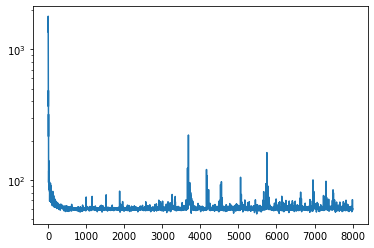

In [14]:
losses = []
for _ in range(8000):
    losses.append(svi.step())

plt.semilogy(losses);

In [15]:
def gp_autoguide_forward(model, X, num_samples=1):
    
    temp_model = copy.deepcopy(model)
    
    predictive = pyro.infer.Predictive(temp_model, guide=guide, num_samples=num_samples)
    
    temp_model.lengthscale = predictive(X)['kernel.lengthscale']
    temp_model.variance = predictive(X)['kernel.variance']
    temp_model.noise = predictive(X)['noise']
    
    mu, sigma = temp_model(X)
    
    return mu, sigma

In [16]:
normal_phi = lambda x: torch.exp(-x.pow(2)/2)/np.sqrt(2*np.pi)
normal_Phi = lambda x: (1 + torch.erf(x / np.sqrt(2))) / 2

def autoguide_ei(model, forward_func, x):
    """ Brooks' implementation of expected improvement (EI). """
    
    y_min = model.y.min()
    mu, variance = forward_func(x)
    sigma = variance.sqrt()
    delta = y_min - mu
    EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
    
    return -EI

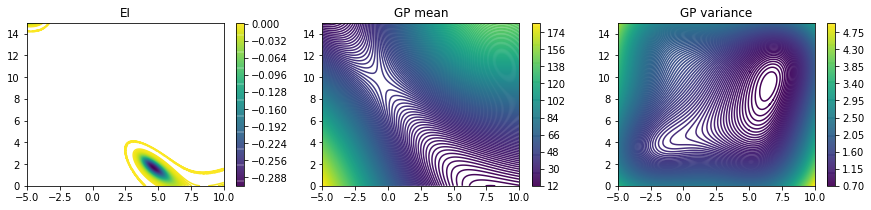

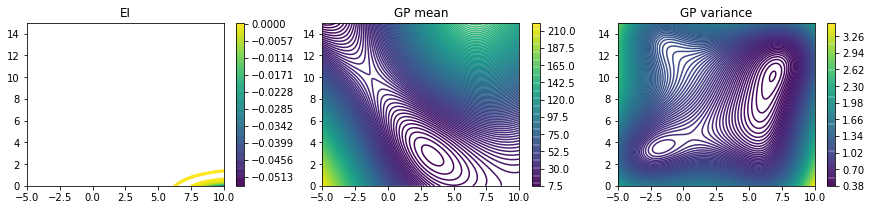

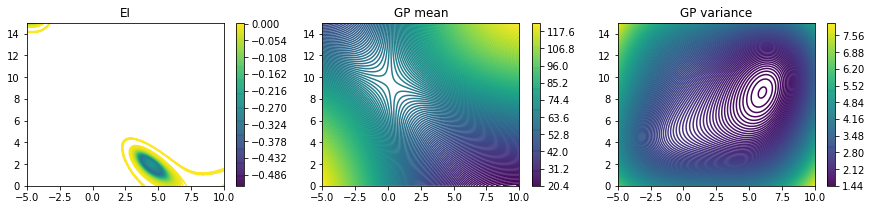

In [17]:
for i in range(3):
    plt.figure(figsize=(15, 3)) 

    with torch.no_grad():
        plt.subplot(1,3,1)
        plt.title("EI")
        
        f_model = lambda x: gp_autoguide_forward(gp_model_svi, x)
        f = lambda x: autoguide_ei(gp_model_svi, f_model, x)
        plot_obj(f)
        
        plt.subplot(1,3,2)
        plt.title("GP mean")
        f = lambda x: gp_autoguide_forward(gp_model_svi, x)[0]
        plot_obj(f)
        
        plt.subplot(1,3,3)
        plt.title("GP variance")
        f = lambda x: gp_autoguide_forward(gp_model_svi, x)[1]
        plot_obj(f)

## Brooks's implementation (butchered)

In [18]:
class GPRegressionModule(PyroModule):

    def __init__(self, X, y, kernel):
        """ Defines a PyroModule which wraps GPRegression """
        super().__init__()
        self.X = X
        self.y = y
        self.kernel = kernel
        self.gp = gp.models.GPRegression(X, y, self.kernel)

    @pyro.nn.pyro_method
    def model(self):
        return self.gp.model()
        
    def forward(self, X):
        ''' Predict on new data points '''
        # sample mu, sigma
        mu, sigma = self.gp(X)
        
        # sample value of y
        pyro.sample('y', dist.Normal(mu, sigma))
    
        # compute expected improvement
        y_min = self.y.min()
        delta = y_min - mu
        EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
                
        pyro.sample('EI', dist.Delta(-EI))

        # return the mean, in case we want to ignore the GP noise for some reason later
        return mu

In [19]:
set_random_seed(123)

pyro.clear_param_store()

# Define the model
kernel = gp.kernels.Matern52(input_dim=X_train.shape[1], 
                    lengthscale=100*torch.ones(X_train.shape[1]))
gp_as_module = GPRegressionModule(X_train, y_train, kernel)

# Set priors
gp_as_module.gp.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(3, 1).expand([2]).to_event())
gp_as_module.gp.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(5, 2))
gp_as_module.gp.noise = pyro.nn.PyroSample(dist.LogNormal(0, 1))

# Autoguide
guide = autoguide.AutoMultivariateNormal(gp_as_module.model)

# Optimizer
optimizer = pyro.optim.Adam({"lr":0.01})
loss = Trace_ELBO()
svi = SVI(gp_as_module.model, guide, optimizer, loss)

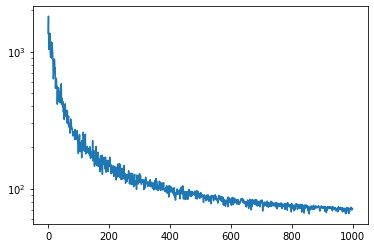

In [20]:
# do gradient steps
losses = []
for _ in range(1000):
    losses.append(svi.step())
    
plt.semilogy(losses);

**Comment:** it seems that predictive calls forward n + 2 times where n is the number of samples, and only during the last n calls parameters are sampled from the posterior distribution.

#### num_samples = 1

In [21]:
x_new = torch.tensor([[0.1, 0.2]])
predictive = pyro.infer.Predictive(gp_as_module, guide=guide, num_samples=1, return_sites=('y', 'EI'))

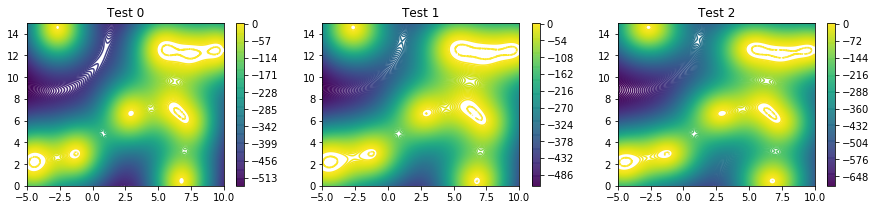

In [22]:
plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: predictive(X)['EI'].mean(0))

#### num_samples = 17

In [23]:
x_new = torch.tensor([[0.1, 0.2]])
predictive = pyro.infer.Predictive(gp_as_module, guide=guide, num_samples=17, return_sites=('y', 'EI'))

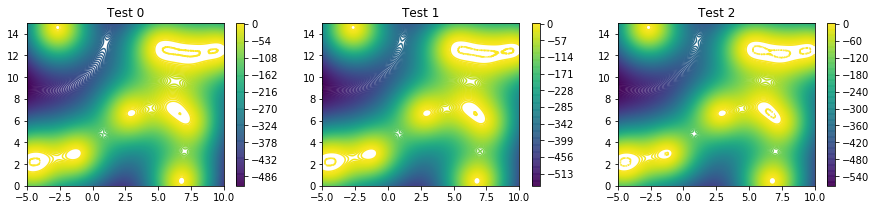

In [24]:
plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: predictive(X)['EI'].mean(0))